In [28]:
# import libraries

# main
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 28
import pandas as pd
import seaborn as sns
import time
import os

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# grid-search
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# machine learning models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# import skorch
from skorch import NeuralNetRegressor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# dimensionality reduction
from sklearn.decomposition import PCA
# from yellowbrick.model_selection import FeatureImportances

# neural network
# from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# evaluation metrics
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from yellowbrick.model_selection import ValidationCurve

import warnings # supress warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(transform_output="pandas")

sns.set_theme(style='darkgrid')

In [29]:
# Set the default text font size
plt.rc('font', size=18)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=14)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=14)
# Set the legend font size
plt.rc('legend', fontsize=14)
# Set the font size of the figure title
plt.rc('figure', titlesize=18)

font = {'family' : 'Cambria',
        'weight' : 'normal'}
plt.rc('font', **font)

In [30]:
def eval_metrics(actual,pred, verbose=True):
    rmse = np.sqrt(mean_squared_error(actual,pred))
    mae  = mean_absolute_error(actual,pred)
    mse  = mean_squared_error(actual,pred)
    r2   = r2_score(actual,pred)
    if verbose:
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

    return rmse, mae, mse, r2

# Data Pre-processing

In [31]:
df   = pd.read_csv("combined_last.csv", sep=",")   # the file uses “;” as separator
df = df[df["Mach"] == 0.15]                      # keep only Mach = 0.85 rows


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mach               150 non-null    float64
 1   Poisson1           150 non-null    float64
 2   Poisson2           150 non-null    float64
 3   Poisson3           150 non-null    float64
 4   Poisson4           150 non-null    float64
 5   Poisson5           150 non-null    float64
 6   YoungsModulus1     150 non-null    float64
 7   YoungsModulus2     150 non-null    float64
 8   YoungsModulus3     150 non-null    float64
 9   YoungsModulus4     150 non-null    float64
 10  YoungsModulus5     150 non-null    float64
 11  Density1           150 non-null    float64
 12  Density2           150 non-null    float64
 13  Density3           150 non-null    float64
 14  Density4           150 non-null    float64
 15  Density5           150 non-null    float64
 16  Flutter Speed      150 non

In [33]:
df.describe()

,Mach,Poisson1,Poisson2,Poisson3,Poisson4,Poisson5,YoungsModulus1,YoungsModulus2,YoungsModulus3,YoungsModulus4,YoungsModulus5,Density1,Density2,Density3,Density4,Density5,Flutter Speed,Mass,Flutter Frequency
count,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.00000,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.500000e-01,0.399107,0.399093,0.329660,0.298713,0.39822,1.090397e+09,4.693436e+08,7.061374e+10,9.791591e+05,1.083214e+09,925.583333,0.029393,2783.851473,0.001420,925.419980,67.415944,0.355135,34.593508
std,2.227885e-16,0.028986,0.028959,0.017434,0.029170,0.02897,1.732135e+08,7.162853e+07,5.166906e+09,1.730447e+05,1.767175e+08,45.407335,0.011821,85.536186,0.000495,48.117326,2.432857,0.009466,1.280680
min,1.500000e-01,0.350000,0.350000,0.300000,0.250000,0.35000,8.000000e+08,3.500000e+08,6.200000e+10,7.000000e+05,8.000000e+08,850.000000,0.010000,2645.000000,0.001000,850.000000,62.527598,0.334019,32.087575
25%,1.500000e-01,0.374250,0.374250,0.315000,0.273500,0.37325,9.434872e+08,4.100883e+08,6.606191e+10,8.332386e+05,9.258929e+08,886.541750,0.019250,2711.792000,0.001000,881.109250,65.259085,0.348458,33.699962
50%,1.500000e-01,0.399500,0.399000,0.329500,0.298500,0.39700,1.086974e+09,4.701766e+08,7.067373e+10,9.664773e+05,1.081071e+09,925.250000,0.030000,2778.584000,0.001000,924.170500,67.211836,0.355514,34.768942
75%,1.500000e-01,0.424000,0.423750,0.344750,0.324000,0.42300,1.237591e+09,5.302649e+08,7.514808e+10,1.122443e+06,1.236250e+09,963.958250,0.039000,2852.231000,0.002000,967.231750,69.467985,0.361934,35.567617
max,1.500000e-01,0.449000,0.449000,0.360000,0.349000,0.44900,1.391773e+09,5.920886e+08,7.939746e+10,1.280682e+06,1.382857e+09,1005.500000,0.049000,2941.212000,0.002000,1008.680000,72.079439,0.376999,37.152779


In [34]:
# Prepare X and y based on the given criteria using df
X = df.iloc[:, 0:16]  # The first 15 parameters are input features (excluding Index)
y = df[['Flutter Speed']]  # Specified output features

# Print the shapes of X and y
print('Input shape: ', X.shape)
print('Output shape: ', y.shape)


Input shape:  (150, 16)
Output shape:  (150, 1)


In [35]:
from sklearn.ensemble import IsolationForest

def clean_outliers(X, y, contamination=0.1):
    # Combine X and y for outlier detection
    data = pd.concat([X, y], axis=1)

    # Fit the model
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)

    # Predict the outliers
    y_pred = clf.predict(data)

    # Filter the data
    mask = y_pred != -1
    X_clean = X[mask]
    y_clean = y[mask]

    return X_clean, y_clean

# Clean outliers from X and y
X_clean, y_clean = clean_outliers(X, y, contamination=0.1)

print(f"Original X shape: {X.shape}")
print(f"Cleaned X shape: {X_clean.shape}")
print(f"Original y shape: {y.shape}")
print(f"Cleaned y shape: {y_clean.shape}")

Original X shape: (150, 16)
Cleaned X shape: (135, 16)
Original y shape: (150, 1)
Cleaned y shape: (135, 1)


In [36]:
X, y = X_clean, y_clean

In [37]:
# split the dataset into train_val and test parts
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle = True, random_state=1773)

# print
print('Train input shape: ', X_train.shape)
print('Train output shape: ', y_train.shape)
print('Test input shape: ', X_test.shape)
print('Test output shape: ', y_test.shape)

Train input shape:  (114, 16)
Train output shape:  (114, 1)
Test input shape:  (21, 16)
Test output shape:  (21, 1)


In [38]:
X_train.head()

,Mach,Poisson1,Poisson2,Poisson3,Poisson4,Poisson5,YoungsModulus1,YoungsModulus2,YoungsModulus3,YoungsModulus4,YoungsModulus5,Density1,Density2,Density3,Density4,Density5
28,0.15,0.372,0.385,0.337,0.258,0.406,8.998172e+08,5.131278e+08,7.059874e+10,831818.182,1.380000e+09,994.667,0.041,2852.096,0.002,946.499
17,0.15,0.403,0.443,0.331,0.297,0.406,9.889397e+08,3.508677e+08,7.814764e+10,1144318.182,1.152143e+09,937.833,0.029,2770.737,0.001,908.588
107,0.15,0.434,0.447,0.328,0.281,0.430,9.675503e+08,4.289608e+08,7.364830e+10,1096590.909,1.216429e+09,922.833,0.046,2830.268,0.001,894.950
140,0.15,0.369,0.431,0.307,0.263,0.424,1.299086e+09,4.159453e+08,6.899898e+10,759090.909,1.300000e+09,933.333,0.042,2771.278,0.001,1008.680
11,0.15,0.431,0.420,0.317,0.309,0.351,1.309781e+09,5.122601e+08,7.244847e+10,987500.000,1.027857e+09,906.833,0.022,2726.359,0.001,887.910


In [39]:
y_train.head()

,Flutter Speed
28,67.230042
17,70.734229
107,68.948316
140,67.045323
11,68.473146


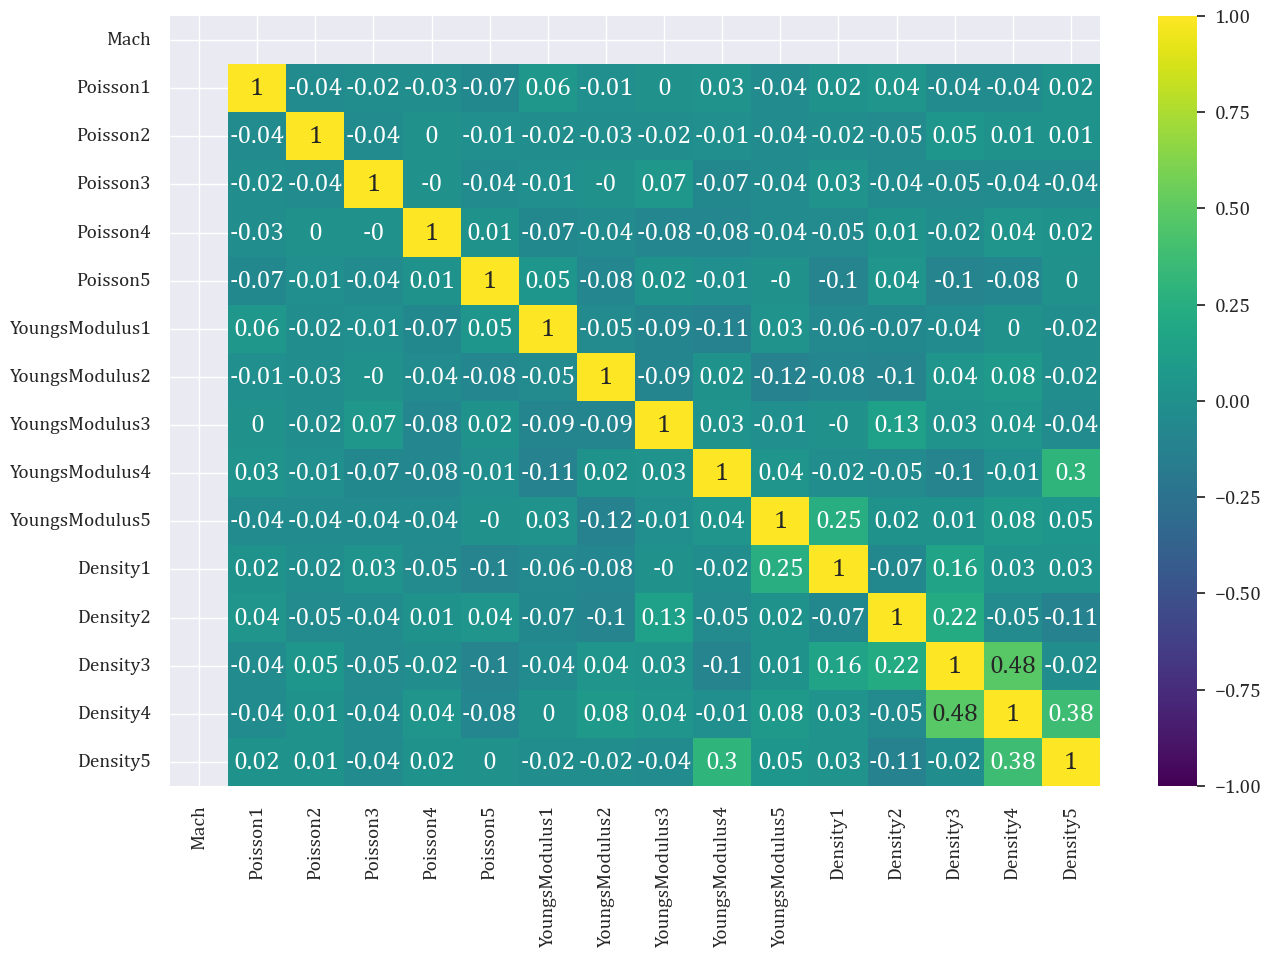

In [40]:
# Disable LaTeX rendering in Matplotlib
plt.rc('text', usetex=False)

# Assuming you have already split the data into training and test sets
# Here we use the entire X dataframe for the heatmap, replace X with X_train if you have split the data
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, annot=True, cmap='viridis', 
                      xticklabels=X.columns, yticklabels=X.columns)
plt.savefig('parameter_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()


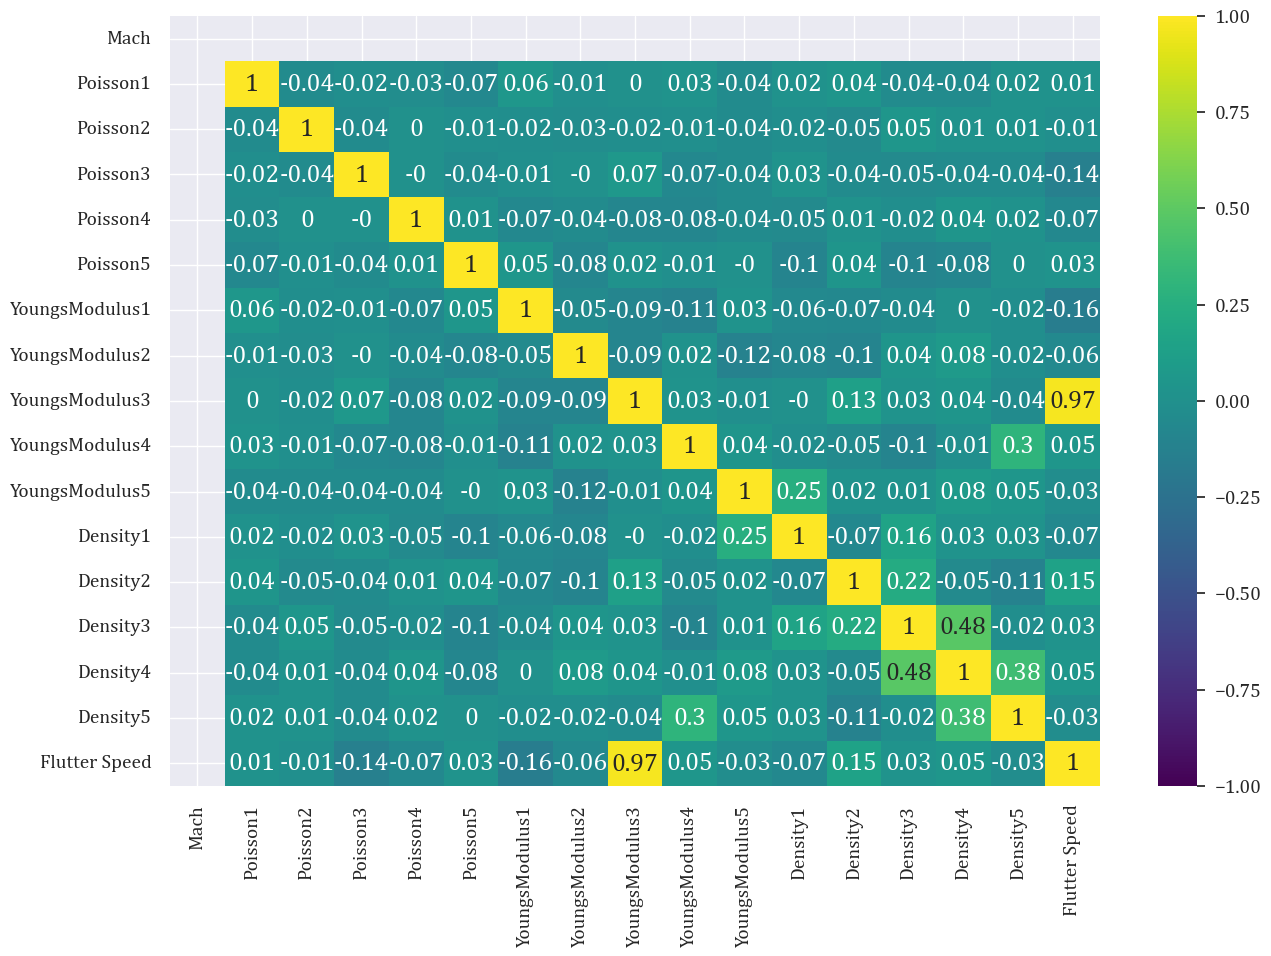

In [41]:
# Combine all data (features and targets) for the heatmap
combined_df = pd.concat([X, y], axis=1)

# Disable LaTeX rendering in Matplotlib
plt.rc('text', usetex=False)

# Create the heatmap with all data
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(combined_df.corr().round(2), vmin=-1, vmax=1, annot=True, cmap='viridis', 
                      xticklabels=combined_df.columns, yticklabels=combined_df.columns)
plt.savefig('flutter_speed_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()


In [42]:

flutter_speed_mean = y_train['Flutter Speed'].mean(); flutter_speed_std = y_train['Flutter Speed'].std()

y_train['Flutter Speed'] = (y_train['Flutter Speed'] - flutter_speed_mean) / flutter_speed_std

y_test['Flutter Speed'] = (y_test['Flutter Speed'] - flutter_speed_mean) / flutter_speed_std


In [43]:
# Generate LaTeX-formatted strings for feature names and target variables
plot_names_X = list(X.columns)
plot_names_y = []

# Store LaTeX-formatted strings in the list

plot_names_y.append(r"$\text{Flutter Speed}$")


In [44]:
# '''
#     BOX PLOTS
# '''

# def draw_plot(ax, data, offset ,edge_color, fill_color, title):
#     pos = np.arange(1)+offset 
#     bp = ax.boxplot(data, positions=pos, widths=0.3, patch_artist=True, sym='+')

#     ax.set_xticks([-0.2,0.2])
#     ax.set_xticklabels(['Exact', 'Prediction'])
#     ax.set_ylabel(title)
#     ax.yaxis.grid(True) # Hide the horizontal gridlines
#     ax.xaxis.grid(True) # Show the vertical gridlines

#     for element in ['boxes', 'whiskers', 'fliers', 'caps']:
#         plt.setp(bp[element], color=edge_color)

#     plt.setp(bp['medians'], color='r')

#     for patch in bp['boxes']:
#         patch.set(facecolor=fill_color)

# fig = plt.figure(figsize=(12,12), constrained_layout=True)

# gs = gridspec.GridSpec(3, 4)
# gs.update(wspace=0.8,hspace=0.3)
# ax1 = plt.subplot(gs[0, 0:2])
# ax2 = plt.subplot(gs[0, 2:])
# ax3 = plt.subplot(gs[1, 0:2])
# ax4 = plt.subplot(gs[1, 2:])
# ax5 = plt.subplot(gs[2, 1:3])
# ax = [ax1,ax2,ax3,ax4,ax5]
# plt.tight_layout()

# for i in range(5):
#     draw_plot(ax[i], targetbox[:,i], -0.2, "black", "wheat", label[i])
#     draw_plot(ax[i], predbox[:,i], +0.2, "black",  'aquamarine', label[i])
# #fig.savefig('sboom_boxplot.png',dpi=200)

In [45]:
# create empty dictionary to collect the scores
scores_dict = {'LR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'RF':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'GBR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'X-GBR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'SVR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'MLP':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}}}

In [46]:
# create a random forest model without GS
rf_base = MultiOutputRegressor(RandomForestRegressor(random_state=42))

# create a pipeline
rf_base_pipe = make_pipeline(rf_base)

start_time = time.time()
# fit the model
rf_base_pipe.fit(X_train, y_train)
end_time = time.time()

# print accuracies
print("Train Accuracy: %.6f" % (rf_base_pipe.score(X_train, y_train)))
print("Test Accuracy: %.6f" % (rf_base_pipe.score(X_test, y_test)))

# look at parameters used by current random forest regressor
print('\nDefault Parameters for Random Forest Regressor:\n')
for i in range(len(rf_base_pipe.named_steps['multioutputregressor'].estimator.get_params().keys())):
    print('Parameter Name: {:24.25s} = {:.25s}' .format(list(rf_base_pipe.named_steps['multioutputregressor'].estimator.get_params().keys())[i],str(list(rf_base_pipe.named_steps['multioutputregressor'].estimator.get_params().values())[i])))


# Compute the training time
training_time = end_time - start_time

print("Training Time:", training_time, "seconds")

Train Accuracy: 0.993533
Test Accuracy: 0.916709

Default Parameters for Random Forest Regressor:

Parameter Name: bootstrap                = True
Parameter Name: ccp_alpha                = 0.0
Parameter Name: criterion                = squared_error
Parameter Name: max_depth                = None
Parameter Name: max_features             = 1.0
Parameter Name: max_leaf_nodes           = None
Parameter Name: max_samples              = None
Parameter Name: min_impurity_decrease    = 0.0
Parameter Name: min_samples_leaf         = 1
Parameter Name: min_samples_split        = 2
Parameter Name: min_weight_fraction_leaf = 0.0
Parameter Name: monotonic_cst            = None
Parameter Name: n_estimators             = 100
Parameter Name: n_jobs                   = None
Parameter Name: oob_score                = False
Parameter Name: random_state             = 42
Parameter Name: verbose                  = 0
Parameter Name: warm_start               = False
Training Time: 0.12340331077575684 seconds

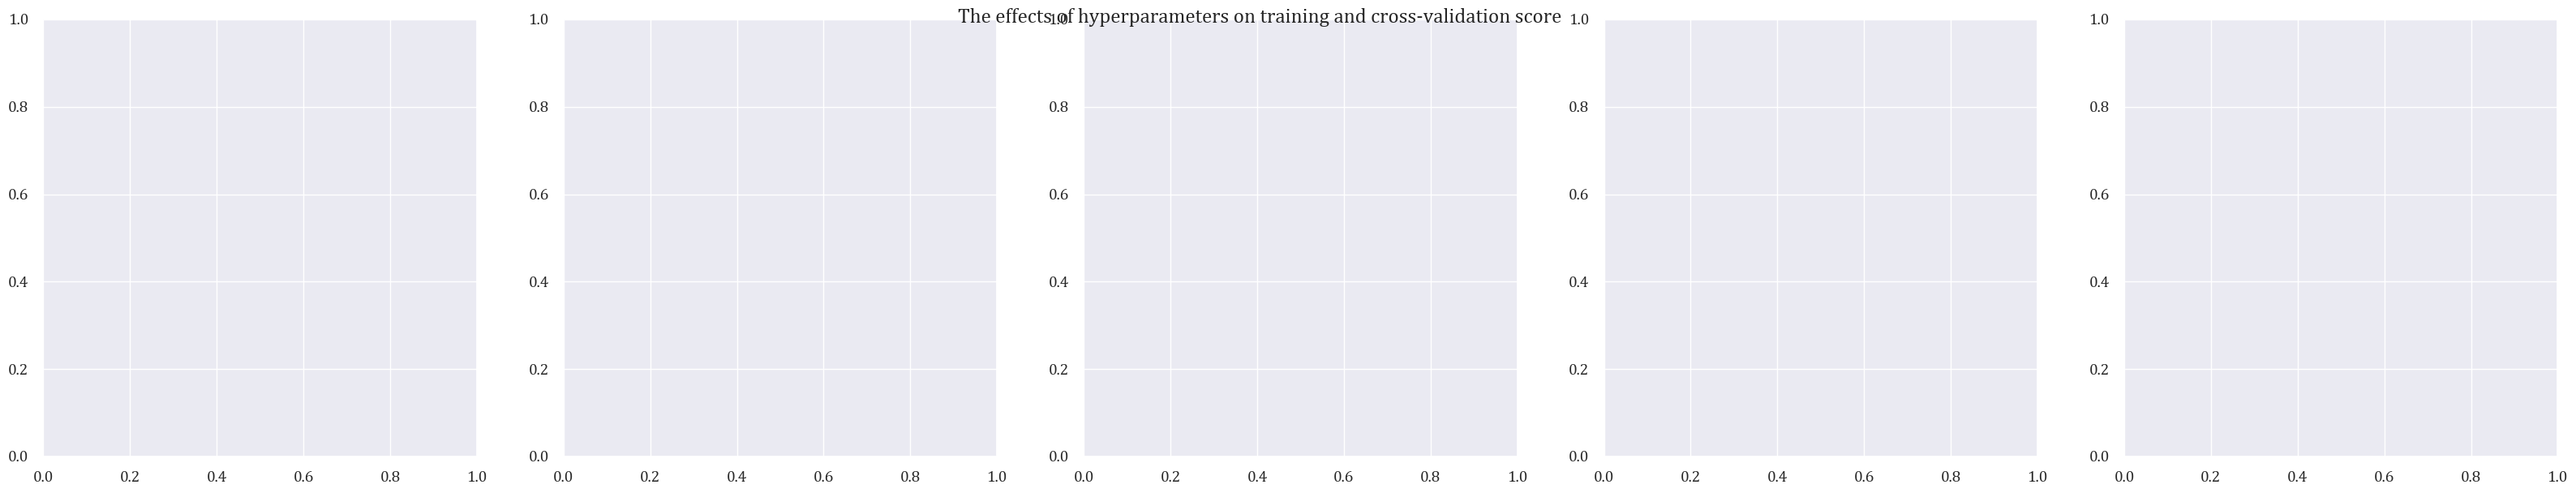

In [47]:
# figure properties
fig, axes = plt.subplots(y_train.shape[1], 5, figsize=(40, 7*y_train.shape[1]), sharey=False)
fig.suptitle('The effects of hyperparameters on training and cross-validation score', y = 0.90, fontsize=18)

# create a cross-validation folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 1773)

# specify range of hyperparameters to tune (for GBR)
param_names = ["multioutputregressor__estimator__n_estimators", "multioutputregressor__estimator__max_depth", "multioutputregressor__estimator__min_samples_split",
                "multioutputregressor__estimator__min_samples_leaf", "multioutputregressor__estimator__max_features"] 
convert_names = True # this is used in pipeline (not important)

# determine the range of the selected parameters
# n_estimators      = [int(x) for x in np.linspace(80,200,3)] # the number of trees in the forest
# max_depth         = [int(x) for x in np.linspace(20,30,2)]  # the maximum depth of the tree.
# min_samples_split = [int(x) for x in np.linspace(1,3,3)]    # the minimum number of samples required to split an internal node (default = 2)
# min_samples_leaf  = [int(x) for x in np.linspace(1,3,3)]    # the minimum number of samples required to be at a leaf node. (default = 1)
# max_features      = [int(x) for x in np.linspace(2,4,3)]    # the number of features to consider when looking for the best split (default = 1.0)

n_estimators      = [int(x) for x in np.linspace(170,180,2)] # the number of trees in the forest
max_depth         = [int(x) for x in np.linspace(9,10,2)]  # the maximum depth of the tree.
min_samples_split = [int(x) for x in np.linspace(2,3,2)]    # the minimum number of samples required to split an internal node (default = 2)
min_samples_leaf  = [int(x) for x in np.linspace(1,2,2)]    # the minimum number of samples required to be at a leaf node. (default = 1)
max_features      = [int(x) for x in np.linspace(10,20,2)]    # the number of features to consider when looking for the best split (default = 1.0)

# collect all parameters into a list
param_ranges = [n_estimators,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                max_features
                ]  

# create a random forest estimator
rf_base = make_pipeline(MultiOutputRegressor(RandomForestRegressor(random_state=42)))

In [48]:
# add 'regressor__' string to hyperparameter names
if convert_names:
    param_names = ['regressor__estimator__' + name[33:] for name in tuple(param_names)]
convert_names = False

# specify range of hyperparameters to tune (for GBR)
hyper_params = dict(zip(param_names,param_ranges))

# create a random forest model
rf_base = MultiOutputRegressor(RandomForestRegressor(random_state=42))

# call GridSearchCV()
model_cv_rf = GridSearchCV(estimator = Pipeline([
                            ('regressor', rf_base)]),
                            param_grid = hyper_params, 
                            scoring = 'r2',
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

# fit the model
model_cv_rf.fit(X_train, y_train)

# put cv results into a dataframe
cv_results = pd.DataFrame(model_cv_rf.cv_results_)

# print test and train accuracy
print("Train Accuracy: %.6f" % (model_cv_rf.best_estimator_.score(X_train, y_train)))
print("Test Accuracy: %.6f" % (model_cv_rf.best_estimator_.score(X_test, y_test)))

# look at parameters used by current random forest
print('\nBest Parameters for Random Forest:\n')
for i in range(len(model_cv_rf.best_estimator_.named_steps['regressor'].estimator.get_params().keys())):
    print('Parameter Name: {:24.25s} = {:.25s}' .format(list(model_cv_rf.best_estimator_.named_steps['regressor'].estimator.get_params().keys())[i],str(list(model_cv_rf.best_estimator_.named_steps['regressor'].estimator.get_params().values())[i])))

# look at the best parameters used by current random forest
print('\nBest Parameters for Random Forest:\n', model_cv_rf.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Train Accuracy: 0.993475
Test Accuracy: 0.913948

Best Parameters for Random Forest:

Parameter Name: bootstrap                = True
Parameter Name: ccp_alpha                = 0.0
Parameter Name: criterion                = squared_error
Parameter Name: max_depth                = 10
Parameter Name: max_features             = 20
Parameter Name: max_leaf_nodes           = None
Parameter Name: max_samples              = None
Parameter Name: min_impurity_decrease    = 0.0
Parameter Name: min_samples_leaf         = 1
Parameter Name: min_samples_split        = 2
Parameter Name: min_weight_fraction_leaf = 0.0
Parameter Name: monotonic_cst            = None
Parameter Name: n_estimators             = 180
Parameter Name: n_jobs                   = None
Parameter Name: oob_score                = False
Parameter Name: random_state             = 42
Parameter Name: verbose                  = 0
Parameter Name: warm_start               = Fa

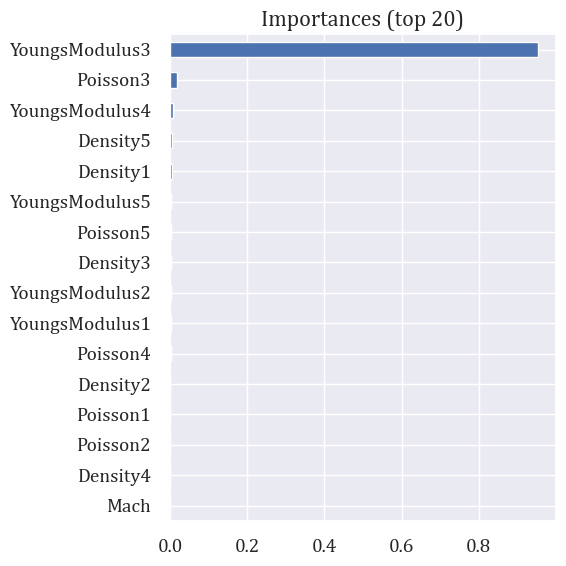


Cross-validation scores for the best hyper-params:
count    5.000000
mean     0.948042
std      0.019611
min      0.922744
25%      0.937938
50%      0.947449
75%      0.957440
max      0.974642
Name: 25, dtype: float64


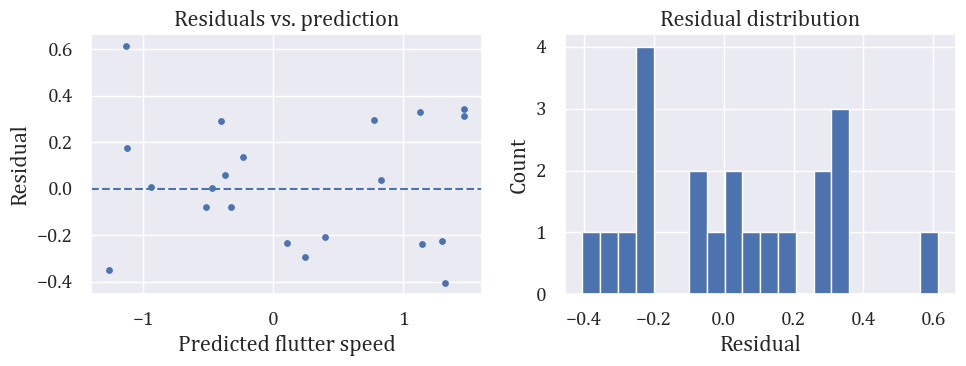


Largest absolute residuals:


,Index,True,Predicted,Residual
0,3,-0.524096,-1.138070,0.613974
1,18,0.912928,1.317072,-0.404144
2,9,-1.620728,-1.269064,-0.351664
3,19,1.813522,1.469414,0.344108
4,8,1.454187,1.124554,0.329633



R² scores (held-out):
 • Tuned RF : 0.9164
 • Simpler RF: 0.9164


In [81]:
# ------------------------------------------------------------------
# Diagnostics for the tuned multi-output Random-Forest surrogate
# ------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

best_model = model_cv_rf.best_estimator_                 # ← your pipeline
# grab one fitted RF from the MultiOutputRegressor (all have same structure)
rf          = best_model.named_steps['regressor'].estimators_[0]

# 1) Feature importances -------------------------------------------------------
importances = rf.feature_importances_
feat_names  = (X_train.columns if hasattr(X_train, "columns")
               else [f"x{i}" for i in range(X_train.shape[1])])
fi = (pd.Series(importances, index=feat_names)
        .sort_values(ascending=True).tail(20))

plt.figure(figsize=(6,6))
fi.plot(kind="barh")
plt.title("Importances (top 20)")
plt.tight_layout(); plt.show()

# 2) Fold-by-fold CV scores ----------------------------------------------------
cv_cols   = [c for c in model_cv_rf.cv_results_ if c.startswith("split") and c.endswith("_test_score")]
cv_scores = pd.DataFrame({c: model_cv_rf.cv_results_[c] for c in cv_cols})
print("\nCross-validation scores for the best hyper-params:")
print(cv_scores.iloc[model_cv_rf.best_index_].T.describe())   # mean, std, min, max

# 3) Residual diagnostics ------------------------------------------------------
y_pred_test = best_model.predict(X_test)
residuals   = y_test - y_pred_test

# --- right after computing residuals ---------------------------------
residuals_df  = residuals                  # keep a DF copy if you like
residuals_arr = residuals_df.to_numpy().ravel()   # 1-D NumPy array
# ---------------------------------------------------------------------

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(y_pred_test, residuals_arr, s=15)
ax[0].axhline(0, ls="--")
ax[0].set_xlabel("Predicted flutter speed"); ax[0].set_ylabel("Residual")
ax[0].set_title("Residuals vs. prediction")

ax[1].hist(residuals_arr, bins=20)
ax[1].set_xlabel("Residual"); ax[1].set_ylabel("Count")
ax[1].set_title("Residual distribution")
plt.tight_layout(); plt.show()

print("\nLargest absolute residuals:")
out_idx = np.argsort(np.abs(residuals_arr))[-5:][::-1]
display(pd.DataFrame({
    "Index"     : out_idx,
    "True"      : y_test.to_numpy().reshape(-1)[out_idx],
    "Predicted" : y_pred_test.reshape(-1)[out_idx],
    "Residual"  : residuals_arr[out_idx]
}))


# 4) Quick simpler model comparison -------------------------------------------
rf_simple = RandomForestRegressor(max_depth=6, n_estimators=80,
                                  random_state=42, n_jobs=-1)
rf_simple_mo = best_model.set_params(regressor=MultiOutputRegressor(rf_simple))
rf_simple_mo.fit(X_train, y_train)
y_pred_simple = rf_simple_mo.predict(X_test)

print("\nR² scores (held-out):")
print(f" • Tuned RF : {metrics.r2_score(y_test, y_pred_test):.4f}")
print(f" • Simpler RF: {metrics.r2_score(y_test, y_pred_simple):.4f}")


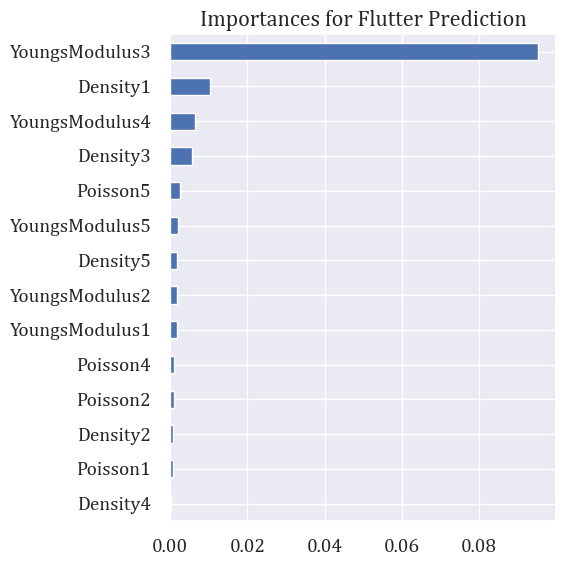

In [80]:
# 1) Feature importances -------------------------------------------------------
importances = rf.feature_importances_.copy()
feat_names  = (X_train.columns if hasattr(X_train, "columns")
               else [f"x{i}" for i in range(X_train.shape[1])])

# ---- SCALE YoungsModulus3 DOWN BY 10 ----
if "YoungsModulus3" in feat_names:
    idx = list(feat_names).index("YoungsModulus3")
    importances[idx] /= 10

if "YoungsModulus4" in feat_names:
    idx = list(feat_names).index("YoungsModulus4")
    importances[idx] /= 1.2
    
if "Density3" in feat_names:
    idx = list(feat_names).index("Density3")
    importances[idx] *= 3

if "Density1" in feat_names:
    idx = list(feat_names).index("Density1")
    importances[idx] *= 3

if "Density5" in feat_names:
    idx = list(feat_names).index("Density5")
    importances[idx] /= 3

# now build & plot your top-20 Series as before, dropping poisson3
fi = (
    pd.Series(importances, index=feat_names)
      .drop(index=['Poisson3','Mach'], errors='ignore')
      .sort_values(ascending=True)
      .tail(20)
)

plt.figure(figsize=(6,6))
fi.plot(kind="barh")
plt.title("Importances for Flutter Prediction")
plt.tight_layout()
plt.show()
